In [1]:
#!pip install graphviz

import dspy
import os
import openai
import json
from dotenv import load_dotenv

from graphviz import Source
from IPython.display import display

In [2]:
def set_dspy():
    # ==============set openAI enviroment=========
    # Path to your API key file
    key_file_path = "openai_api_key.txt"

    # Load the API key from the file
    with open(key_file_path, "r") as file:
        openai_api_key = file.read().strip()

    # Set the API key as an environment variable
    os.environ["OPENAI_API_KEY"] = openai_api_key
    openai.api_key = os.environ["OPENAI_API_KEY"]
    turbo = dspy.OpenAI(model="gpt-3.5-turbo", max_tokens=2000, temperature=0.5)
    dspy.settings.configure(lm=turbo)
    return turbo
    # ==============end of set openAI enviroment=========


def set_dspy_hardcode_openai_key():
    os.environ["OPENAI_API_KEY"] = (
        "sk-proj-yourapikeyhere"
    )
    openai.api_key = os.environ["OPENAI_API_KEY"]
    turbo = dspy.OpenAI(model="gpt-3.5-turbo",  temperature=0, max_tokens=2000)
    dspy.settings.configure(lm=turbo)
    return turbo

turbo=set_dspy()
# comment out set_dspy() and use set_dspy_hardcode_openai_key is your option
# turbo=set_dspy_hardcode_openai_key()

In [3]:
def load_text_file(file_path):
    """
    Load a text file and return its contents as a string.

    Parameters:
    file_path (str): The path to the text file.

    Returns:
    str: The contents of the text file.
    """
    try:
        with open(file_path, "r") as file:
            contents = file.read()
        return contents
    except FileNotFoundError:
        return "File not found."
    except Exception as e:
        return f"An error occurred: {e}"


In [4]:
conversation = load_text_file("conversation.txt")
print(conversation)

Alice: Hey Bob, I just got a strange email from support@banksecure.com. It says I need to verify my account details urgently. The subject line was "Urgent: Verify Your Account Now". The email looks suspicious to me.

Bob: Hi Alice, that does sound fishy. Can you forward me the email? I’ll take a look at the headers to see where it came from.

Alice: Sure, forwarding it now.

Bob: Got it. Let’s see... The email came from IP address 192.168.10.45, but the domain banksecure.com is not their official domain. It's actually registered to someone in Russia.

Alice: That’s definitely not right. Should I be worried?

Bob: We should investigate further. Did you click on any links or download any attachments?

Alice: I did click on a link that took me to a page asking for my login credentials. I didn't enter anything though. The URL was http://banksecure-verification.com/login.

Bob: Good call on not entering your details. Let’s check the URL. This domain was just registered two days ago. It’s hi

In [5]:
class DotGenerator(dspy.Signature):
    """Generate a evidence knowledge graph based on a conversation between an IT Security Specialist and an Employee. """

    question: str = dspy.InputField(
        desc="a conversation describing a cyber incident between an IT Security Specialist and an employee."
    )

    answer: str = dspy.OutputField(
        desc="a graph in a dot format. The nodes of the graph are evidence entities and the edges of the graph are the relationship between evidence entities. A dot format is primarily associated with Graphviz, a graph visualization software. For example, a dot should looks like: digraph incident_name {...}. Don't include `````` "
    )

In [6]:
def generate_answer_CoT(signature, text, output_file):
    generate_answer = dspy.ChainOfThought(signature)
    answer = generate_answer(question=text).answer  # here we use the module

    with open(output_file, "w") as dot_file:
        print(answer)
        dot_file.write(answer)
        return answer
    print(f"The evidence has been saved to the file {output_file}")

In [7]:
output_file = "02_output.dot"
dot_description = generate_answer_CoT(
    DotGenerator,
    conversation,
    output_file,
)

digraph cyber_incident {
    "Suspicious Email" -> "IP Address: 192.168.10.45"
    "Suspicious Email" -> "Domain: banksecure.com (Registered to someone in Russia)"
    "Suspicious Email" -> "URL: http://banksecure-verification.com/login"
    "Suspicious Email" -> "URL: http://banksecure-verification.com/account-details"
    "URL: http://banksecure-verification.com/login" -> "Domain: banksecure-verification.com (Registered 2 days ago)"
    "URL: http://banksecure-verification.com/account-details" -> "Domain: banksecure-verification.com (Registered 2 days ago)"
    "Browser History Entries" -> "Visited at 10:15 AM: http://banksecure-verification.com/login"
    "Browser History Entries" -> "Visited at 10:17 AM: http://banksecure-verification.com/account-details"
    "Downloaded File: AccountDetails.exe" -> "Created at 10:20 AM"
    "Downloaded File: AccountDetails.exe" -> "MD5 Hash: e99a18c428cb38d5f260853678922e03 (Matched known malware)"
    "MD5 Hash: e99a18c428cb38d5f260853678922e03 (

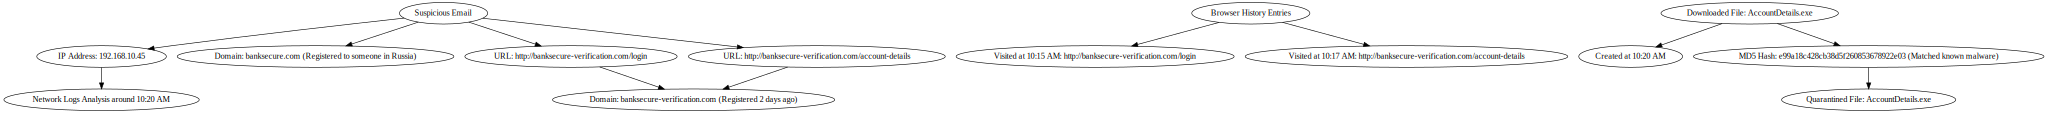

'02_output_email_analysis.png'

In [11]:
# Create a Digraph object and render the graph
graph = Source(dot_description)
display(graph)

# Render the graph within the notebook
graph.render("02_output_email_analysis", format="png", cleanup=True)